Author: **Kajetan Bochajczuk**

*Importing of all necessary libraries and tuning some of the global settings.*

In [1]:
import sklearn.linear_model
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
matplotlib.rcParams['figure.dpi'] = 400
matplotlib.rc('font', family='Lato', size=12)

# Exercise 1
Suppose that $y = X\beta + \epsilon$, where $y$ is $n \times 1$ dimensional vector of observations, $X$ is $n \times p$ design matrix and $\epsilon$ is $n \times 1$ vector of random errors. We are interested in finidng the estimate of $\beta$, i.e. the vector $\hat\beta$. Here, we define $\hat\beta$ as a solutiion to optimization problem:

$$
\text{argmin}_{b \in \mathbf{R}^p} \left\{ \left\lVert y - Xb \right\rVert_2^2 + \lambda\lVert b \rVert_2^2 \right\}
\text,
$$

where $\lambda > 0$ is a fixed (preselected) tuning parameter.

**(a)** Find the analytical solution to ridge estimation problem. Do we get a well defined estimate for any $p>0$ and $n>0$?

**Answer:**

We can rewrite the above formulation as 

$$
\text{argmin}_{b\in\mathbf{R}^p} \left\{ (y - Xb)^\intercal (y - Xb) + \lambda b^\intercal b \right\}
\text.
$$

Then we can derive the first order condition

$$
\frac{\partial}{\partial b^\intercal} \left( (y - Xb)^\intercal (y - Xb) + \lambda b^\intercal b \right) = 0
\text.
$$

Knowing that 

$$
\frac{\partial}{\partial x^\intercal} g(x)^\intercal g(x) = 2 g(x)^\intercal \frac{\partial}{\partial x^\intercal} g(x)
$$

we obtain

$$
2(y - Xb)^\intercal \frac{\partial}{\partial b^\intercal} (y - Xb) + \lambda b^\intercal \frac{\partial}{\partial b^\intercal} b = 0
\text.
$$

Simplifying and rearranging we get the estimator 

$$
\hat\beta= (X^\intercal X + \lambda I_p) ^{-1} X^\intercal y
$$

where $I_p$ is $p \times p$ identity matrix.



**(b)** Derive the formula for $\mathbf{E}\hat{\beta^\lambda}$, where $\hat{\beta^\lambda}$ is ridge estimate for $\lambda > 0$. Is $\hat{\beta^\lambda}$ an unbiased estimate of $\beta$?

**Answer:**

For more readable calculations let us introduce matrix $\Omega = X^\intercal X$. Then

\begin{align}
\hat{\beta^\lambda} &= 
(\Omega + \lambda I_p)^{-1} X^\intercal y = \\ 
&= (\Omega + \lambda I_p)^{-1} \Omega ((X^\intercal X)^{-1} X^\intercal y) = \\
&= (\Omega(I_p + \lambda \Omega^{-1}))^{-1} \Omega \hat{\beta^{LS}} = \\
&= (I_p + \lambda \Omega^{-1})^{-1} \Omega^{-1} \Omega \hat{\beta^{LS}} = \\
&= (I_p + \lambda \Omega^{-1}) \hat{\beta^{LS}}
\end{align}

where $\hat{\beta^{LS}}$ is the estimator of Oridinary Least Squares. Thus we have

\begin{align}
\mathbf{E}\hat{\beta^{\lambda}} &= 
\mathbf{E}(I_p + \lambda \Omega^{-1}) \hat{\beta^{LS}} = \\
&= (I_p + \lambda \Omega^{-1}) \beta
\text.
\end{align}

As we may have expected the bias of the estimator is proportional to $\lambda$. Larger it is, the larger the bias and for $\lambda = 0$ the estimator is unbiased (but then the method is intentical to oridinary least squares).


# Exercise 2
Import data from files `X.csv` and `eps.csv` and treat $X$ as $100$ by $1000$ matrix of experiment and `eps` as $100$ by $1$ vector of random errors, $\epsilon$. Define the vector of true coefficients, $\beta$, by setting $\beta_i = 1$ for $i = 1,\dots, 10$ and $\beta_j = 0$ for $j = 11, \dots, 1000$. Set the intercept, $\beta_0 = 0.5$ and generate observations as $y = \mathbf{1}_n \beta_0 +  X \beta + \epsilon$ and find estimation accuracy and *solution paths* for ridge and lasso estimates, i.e. $\hat{\beta^R}$ and $\hat{\beta^L}$. Precisely;

In [3]:
X = pd.read_csv('X.csv', header=None).values
eps = pd.read_csv('eps.csv', header=None).values

In [4]:
beta = np.zeros((1000, 1))
beta[0] = 0.5
beta[1:11] = 1

In [5]:
y = np.ones_like(eps) * beta[0] + X @ beta + eps

To derive the estimators we will define two simply functions, one for each:

In [6]:
# Ridge
def ridge(X, y, lambda_):
    return (np.linalg.inv(X.T @ X + lambda_ * np.identity(X.shape[1])) @ X.T @ y).flatten()

# Lasso
def lasso(X, y, lambda_):
    return sklearn.linear_model.Lasso(lambda_).fit(X, y).coef_

**(a)** identify $\lambda_L^{MAX} > 0$ such as $\lVert \hat{\beta_L} \rVert_2^2$ drops below $0.05$ first time and $\lambda_R^{MAX}$ such as $\lVert \hat{\beta_R} \rVert_2^2$ drop below $0.05$ first time.

In [7]:
# Lasso
lambda_l_max = None
lambda_ = 0.01
while True:
    norm = np.linalg.norm(lasso(X, y, lambda_), 2) ** 2
    if norm < 0.05:
        lambda_l_max = lambda_
        break
    lambda_ += 0.01
    
# Ridge
lambda_r_max = None
lambda_ = 0.01
while True:
    norm = np.linalg.norm(ridge(X, y, lambda_), 2) ** 2
    if norm < 0.05:
        lambda_r_max = lambda_
        break
    lambda_ += 10

In [8]:
print(f"Maximum lambda for lasso method: {lambda_l_max}")
print(f"Maximum lambda for ridge regression: {lambda_r_max}")

Maximum lambda for lasso method: 1.2000000000000008
Maximum lambda for ridge regression: 3370.01


**(b)** define $50$ values of $\lambda^L$ by putting $\lambda_i^L := \exp \left\{ (i - 1)(\ln\lambda_L^{MAX} + 1) / 49 - 1 \right\}$ and $50$ values of $\lambda^R$ by putting $\lambda_i^R := \exp \left\{ (i - 1)(\ln\lambda_R^{MAX} + 1) / 49 - 1 \right\}$.

In [9]:
N = 50
lambda_ls = np.array([
    np.exp((i - 1) * (np.log(lambda_l_max) + 1) / 49 - 1)
    for i in range(N)
])
lambda_rs = np.array([
    np.exp((i - 1) * (np.log(lambda_r_max) + 1) / 49 - 1)
    for i in range(N)
])

**(c)** generate solution path plots separately for lasso and ridge, i.e. plots which show the evolution of each of the estimated coefficient (coefficients values on $Y$ axis), while $\lambda$ changes (consider the entries of $\lambda^R$ and $\lambda^L$ on $X$ axis). Compare these two plots. Can LASSO recover the set of true nonzero entries of $\beta$ for some range of $\lambda$?

In [10]:
lassos = []
ridges = []
for lambda_l, lambda_r in zip(lambda_ls, lambda_rs):
    lassos.append(lasso(X, y, lambda_l))
    ridges.append(ridge(X, y, lambda_r))
lassos = np.atleast_2d(lassos)
ridges = np.atleast_2d(ridges)

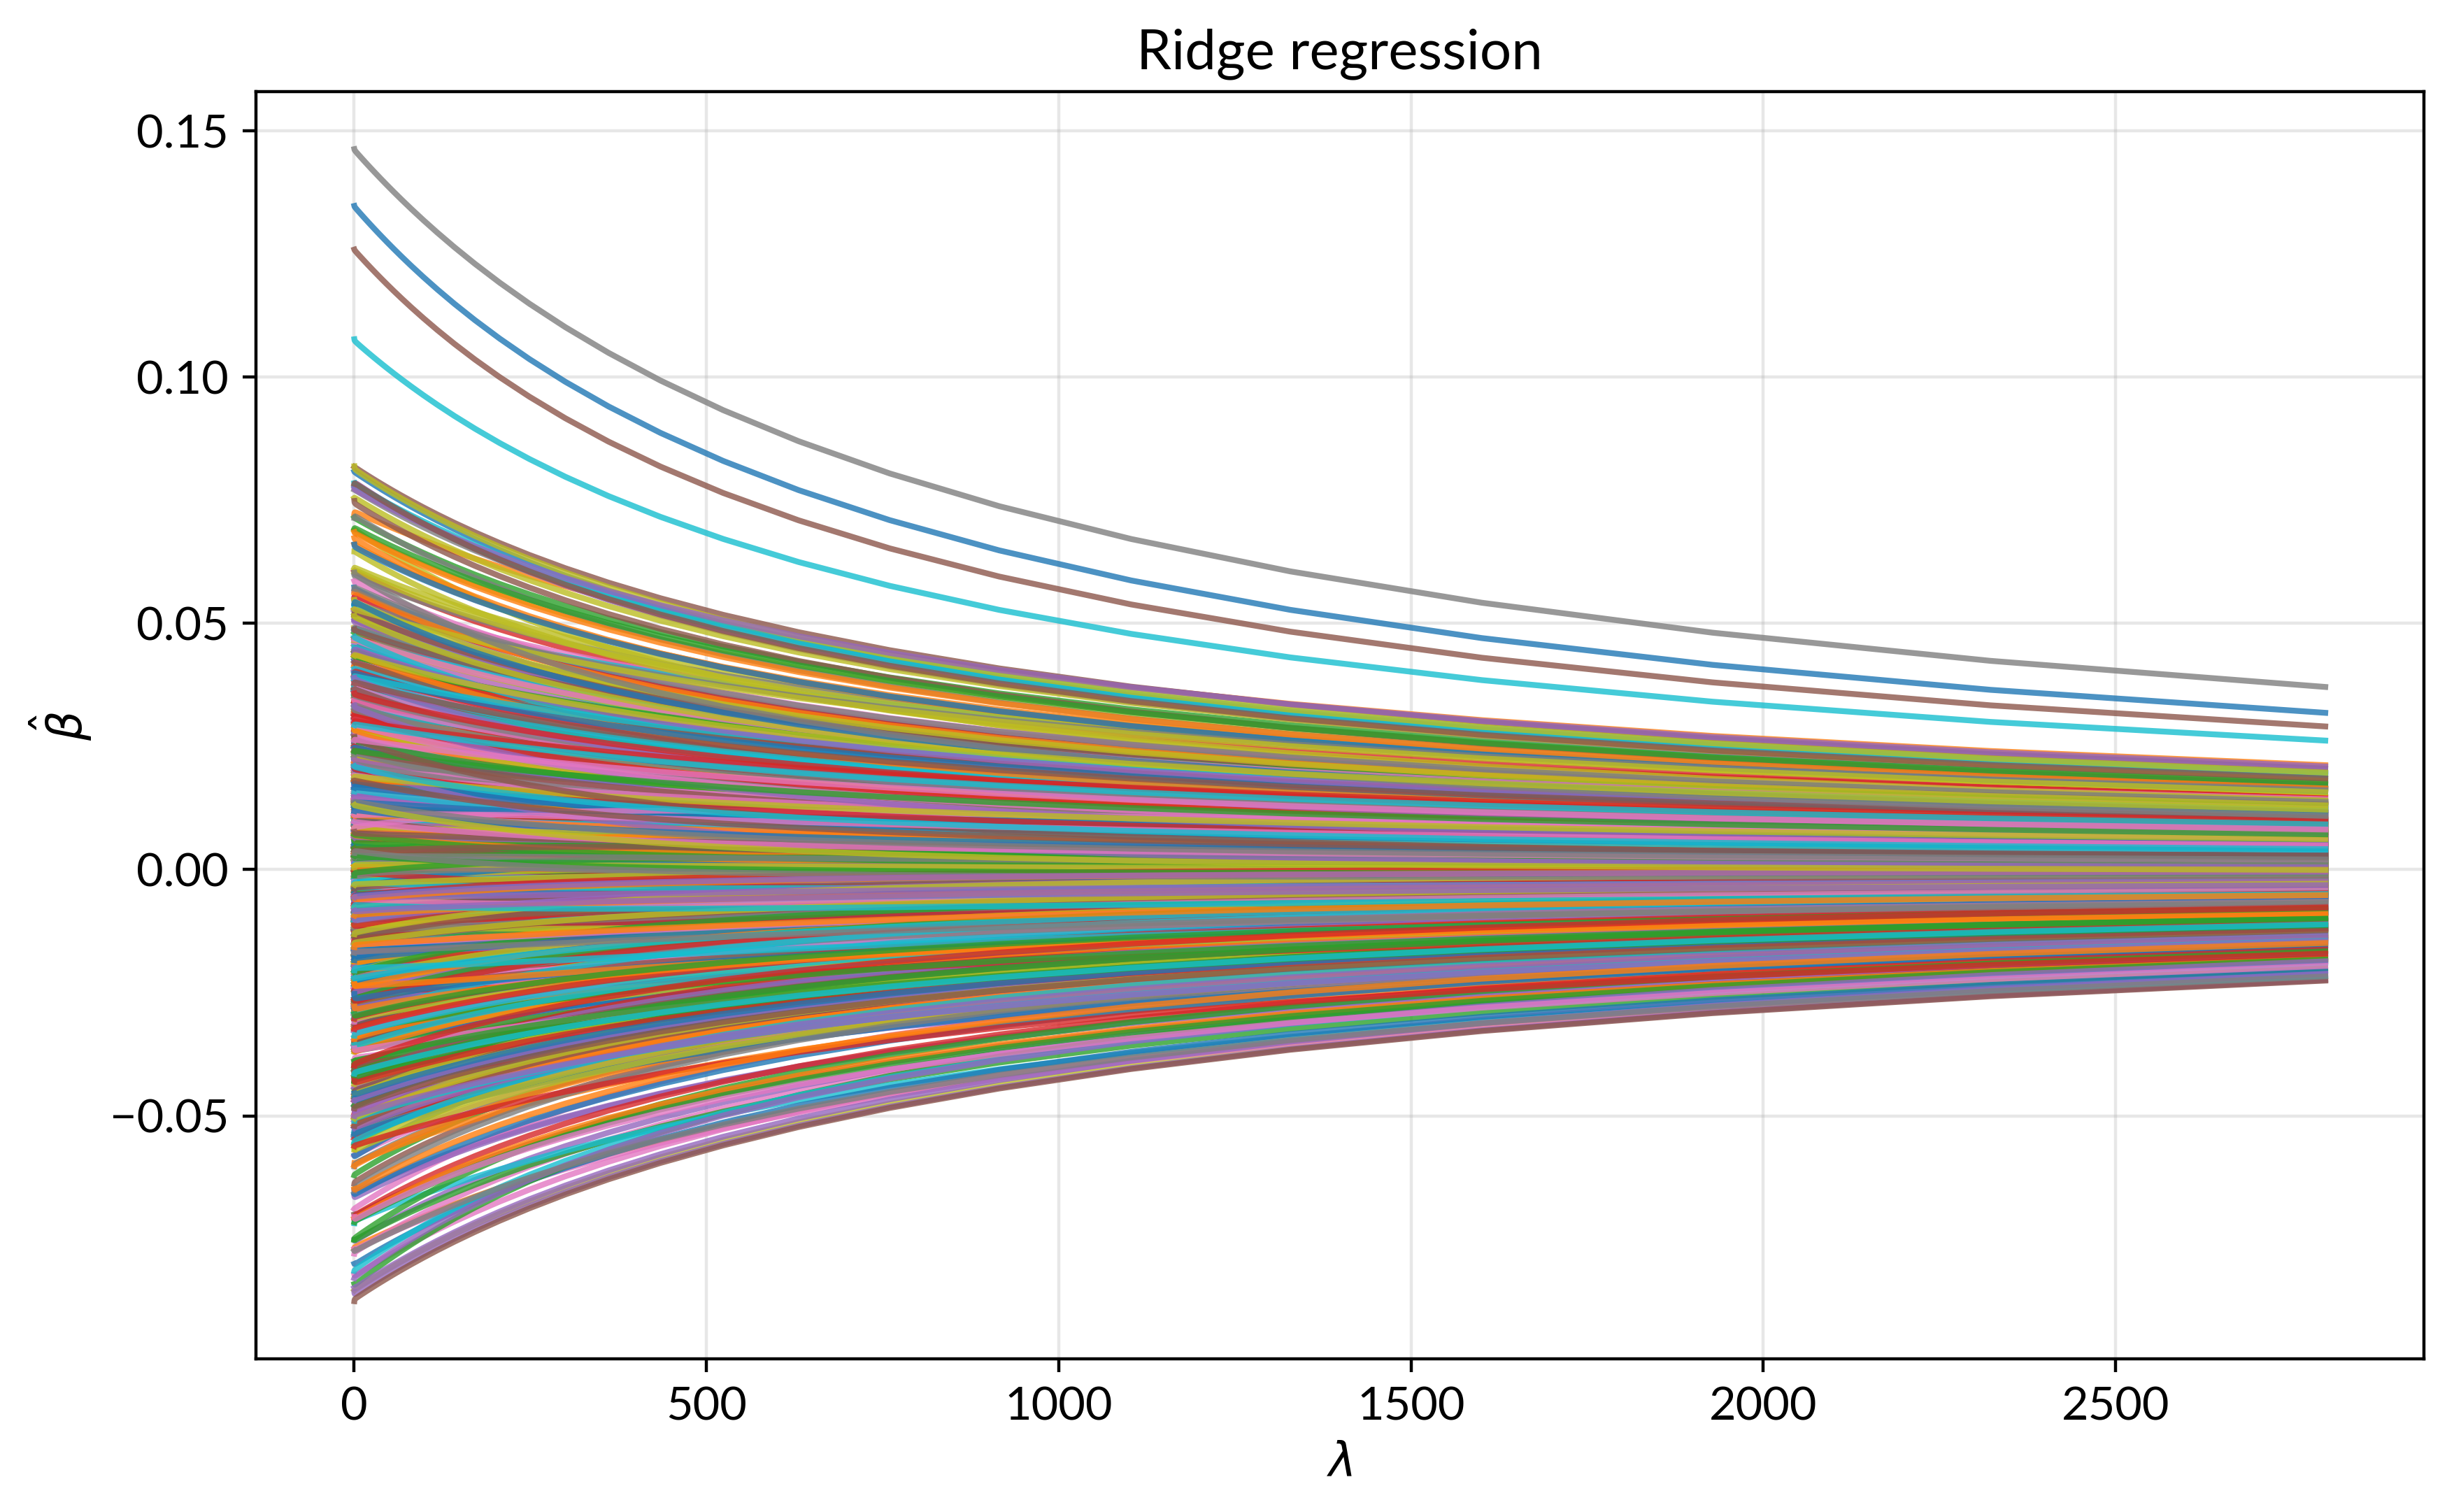

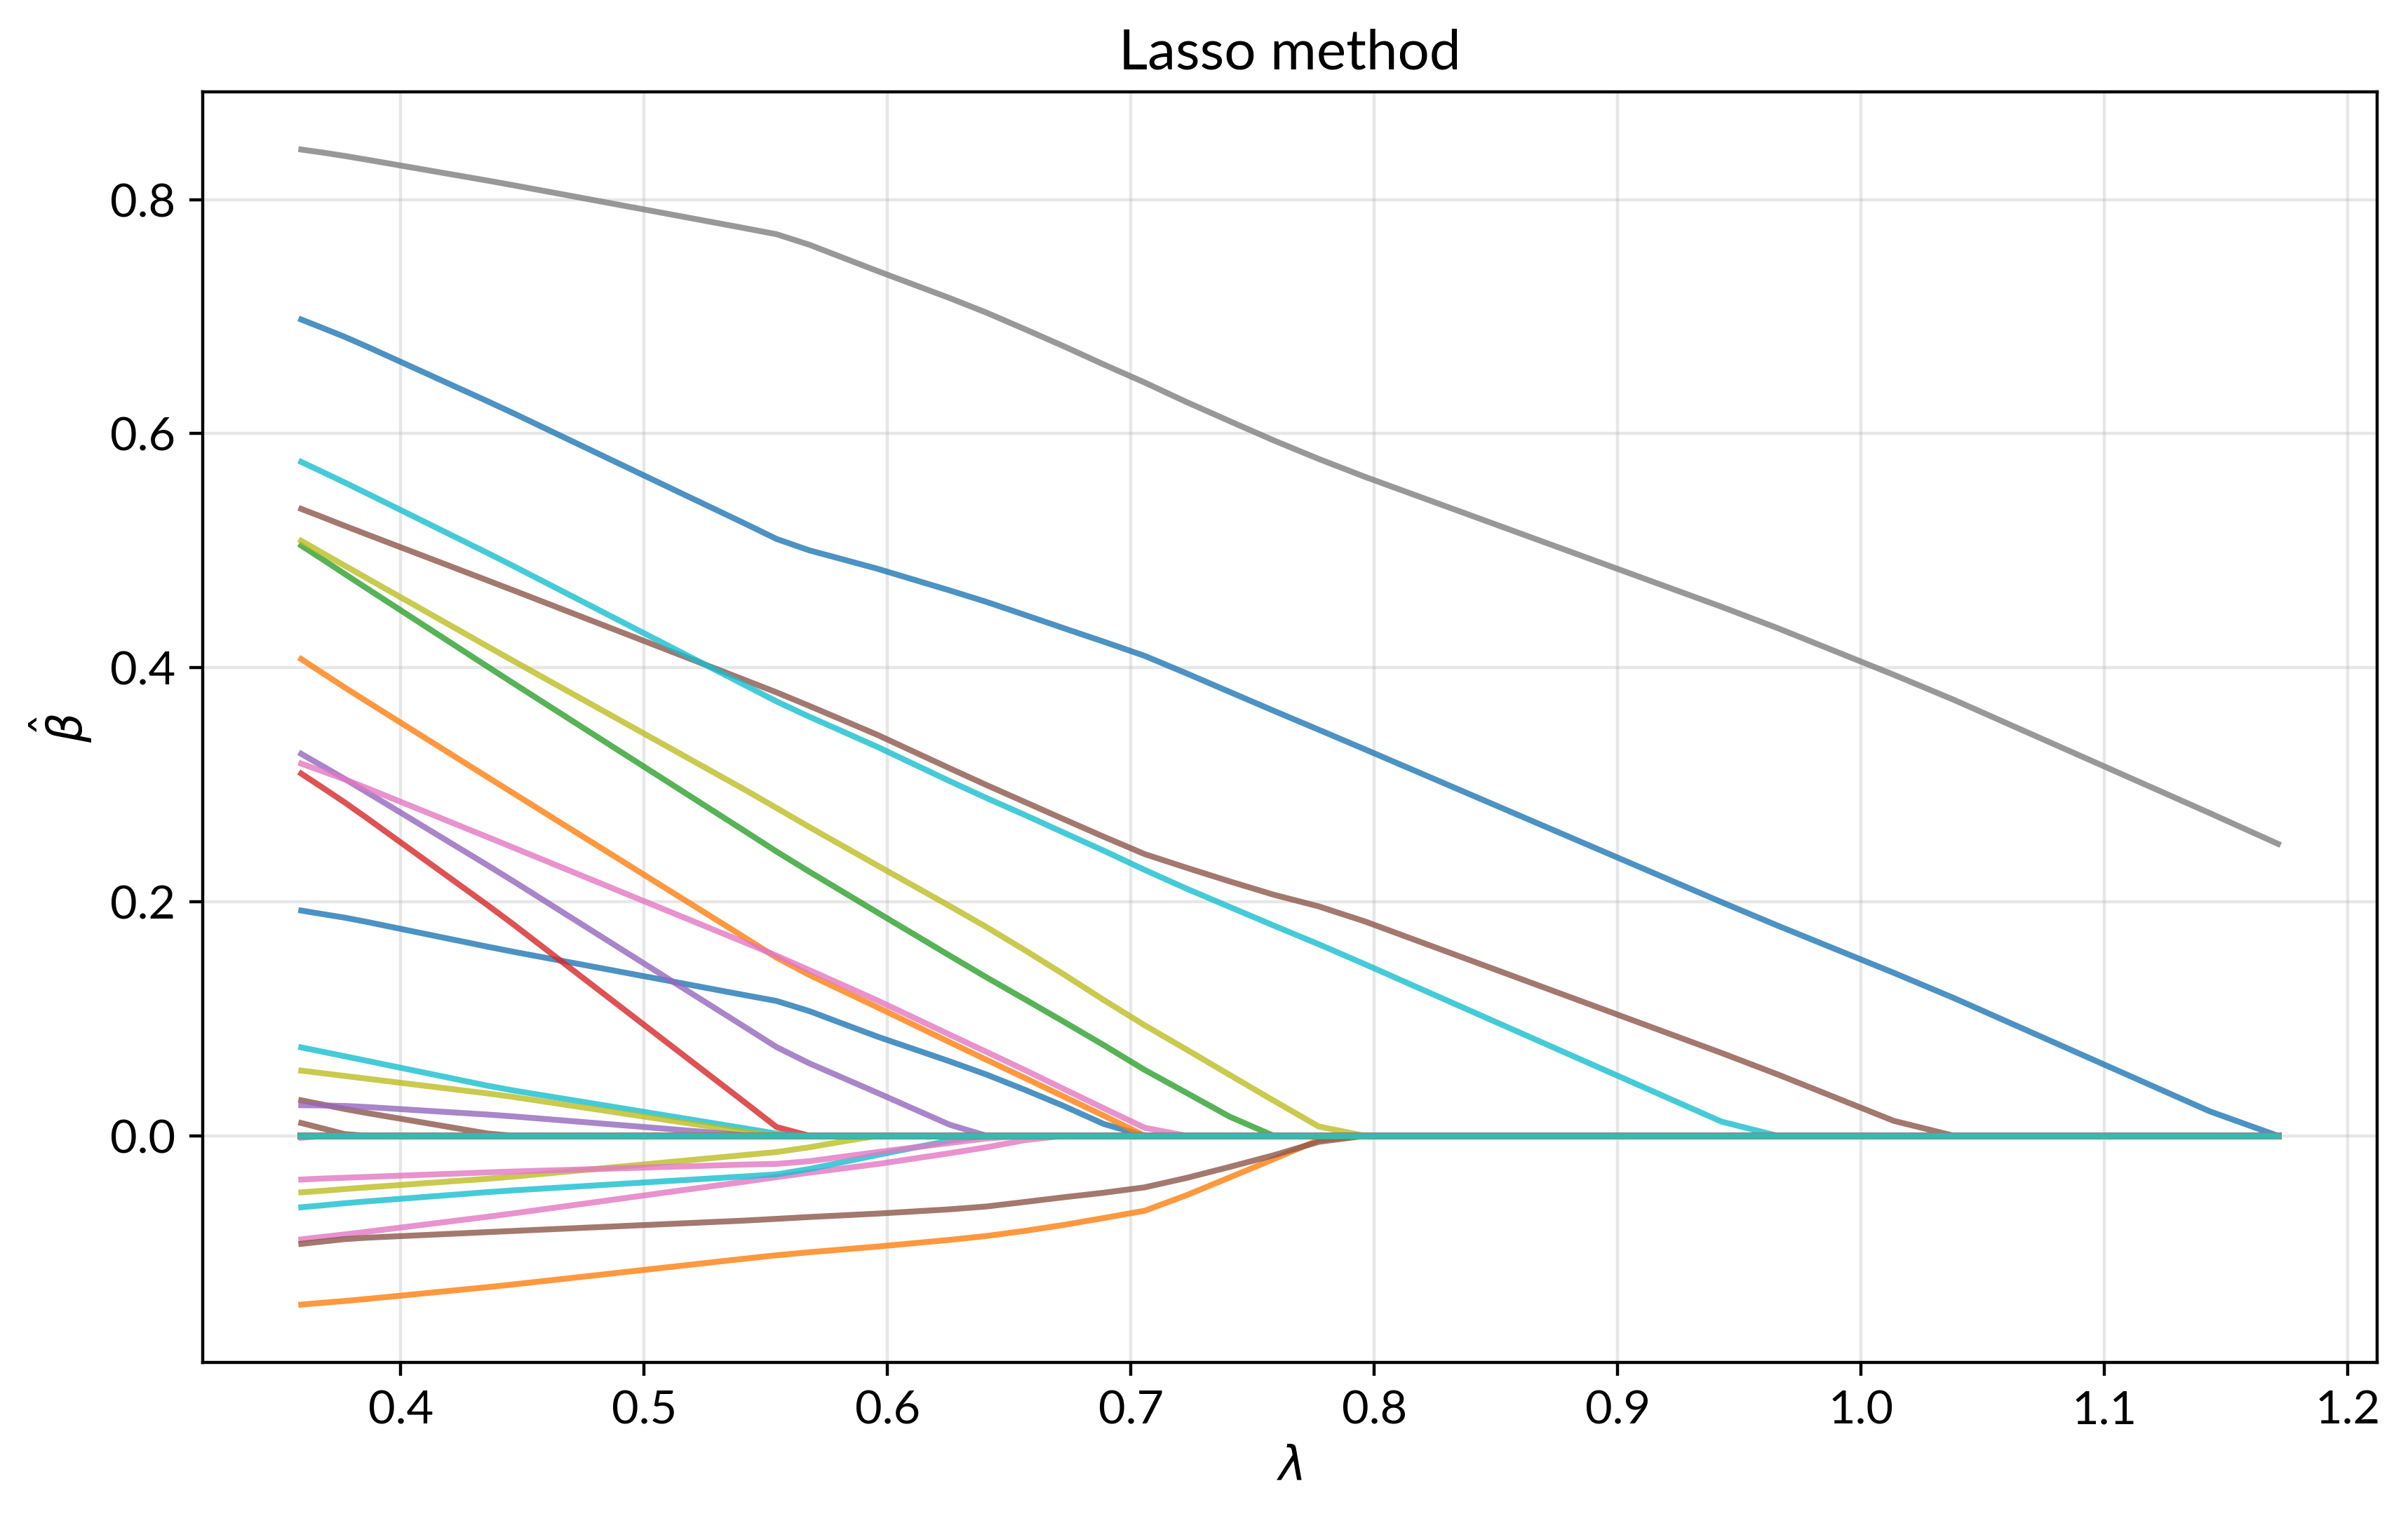

In [11]:
plt.figure()

# Ridge
plt.plot(lambda_rs, ridges, alpha=0.8)
plt.grid(alpha=0.3)
plt.title('Ridge regression')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\hat\beta$')
plt.show()

# Lasso
plt.plot(lambda_ls, lassos, alpha=0.8)
plt.grid(alpha=0.3)
plt.title('Lasso method')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\hat\beta$')
plt.show()

Can LASSO recover the set of true nonzero entries of $\beta$ for some range of $\lambda$?

We should have exactly $11$ nonzero entries of $\beta$:

In [12]:
correct_betas = [_ for _ in lassos if np.linalg.norm(_, ord=0) == 11]

In [13]:
len(correct_betas)

2

We have only two solutions which recover exactly $11$ nonzero entries, but they're still not the correct ones. We can see that in following plot

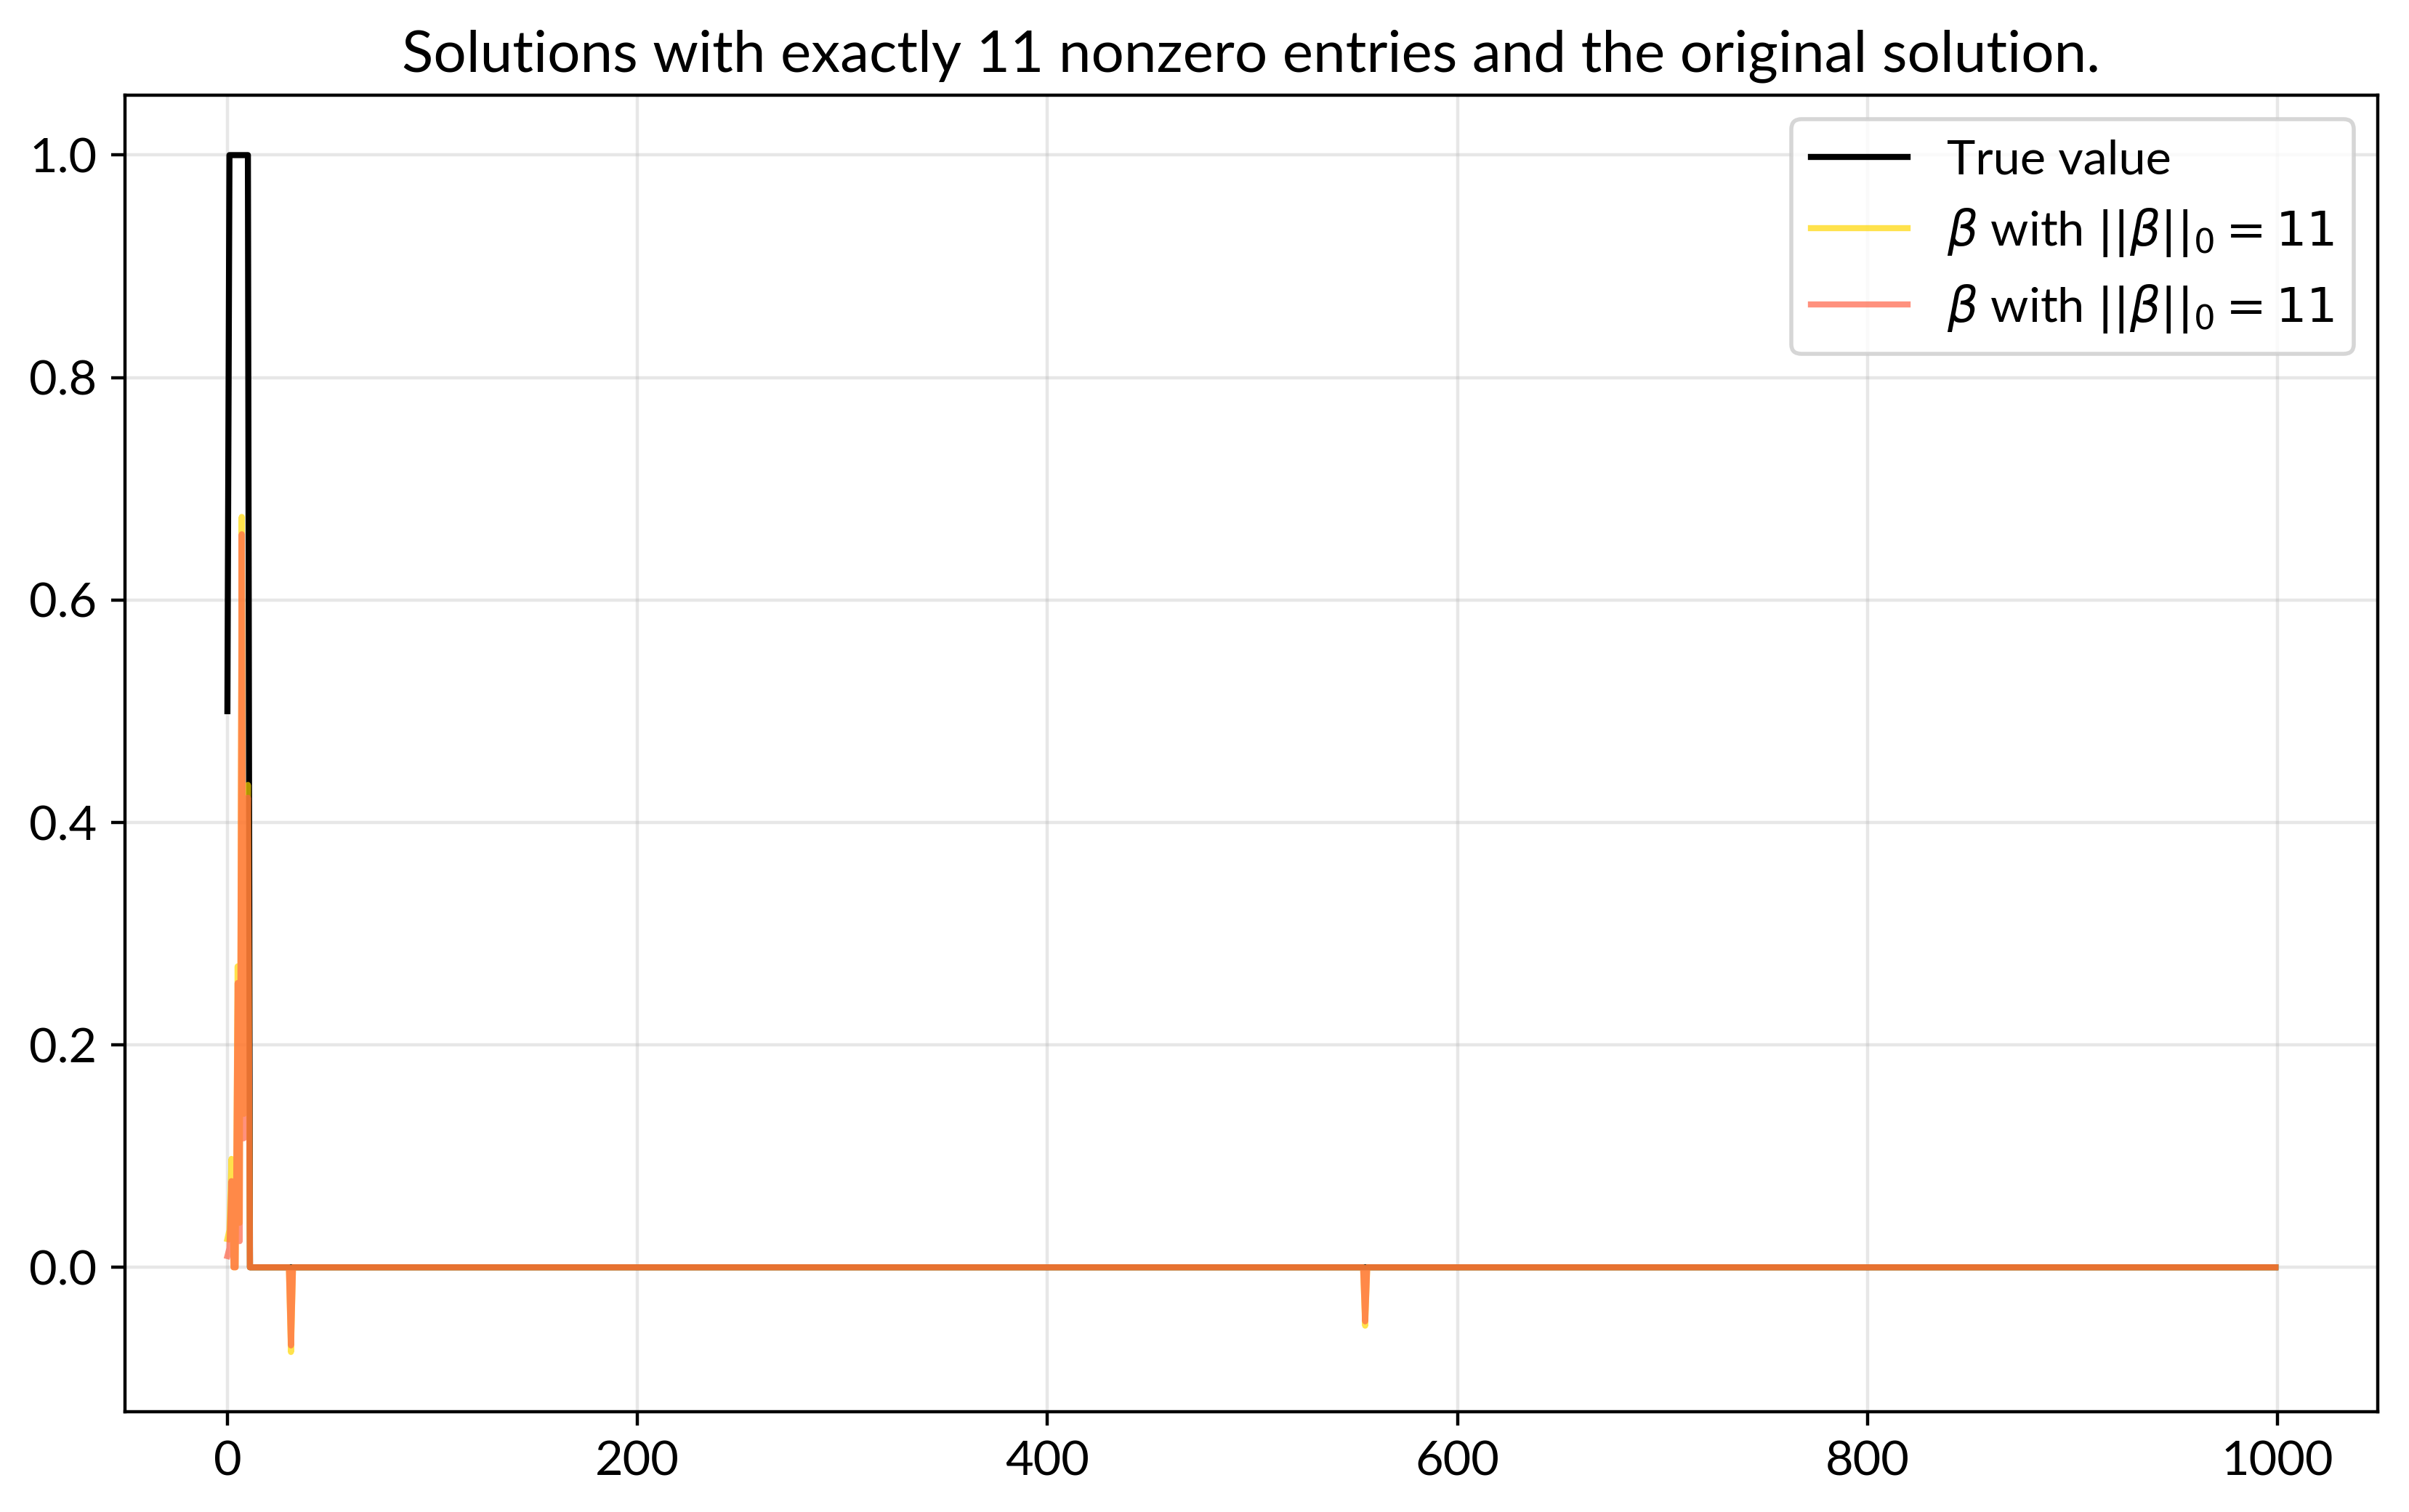

In [14]:
plt.plot(beta, label='True value', color='k')
plt.plot(correct_betas[0], label=r'$\beta$ with $||\beta||_0 = 11$', color='gold', alpha=0.7)
plt.plot(correct_betas[1], label=r'$\beta$ with $||\beta||_0 = 11$', color='tomato', alpha=0.7)
plt.grid(alpha=0.3)
plt.title('Solutions with exactly 11 nonzero entries and the original solution.')
plt.legend()
plt.show()

**(d)** produce the accuracy plot for lasso and ridge (two lines on the same plot) by defining $X$-axis as an index of $\lambda$ vector ($\lambda^R$ or $\lambda^L$) and $Y$-axis as $\lVert \beta - \hat{\beta^\lambda} \rVert_2^2$. What can you say about estimation error for lasso and ridge? Repeat the simuation from d) but this time generate true signal, $\beta$, from $\mathcal{N}(0, I_p)$. What can about the estimation error lines now? Comment the whole eperimetn.

In [15]:
err_l = []
err_r = []
for i in range(len(lambda_ls)):
    err_l.append(np.linalg.norm(beta - lassos[i], 2) ** 2)
    err_r.append(np.linalg.norm(beta - ridges[i], 2) ** 2)

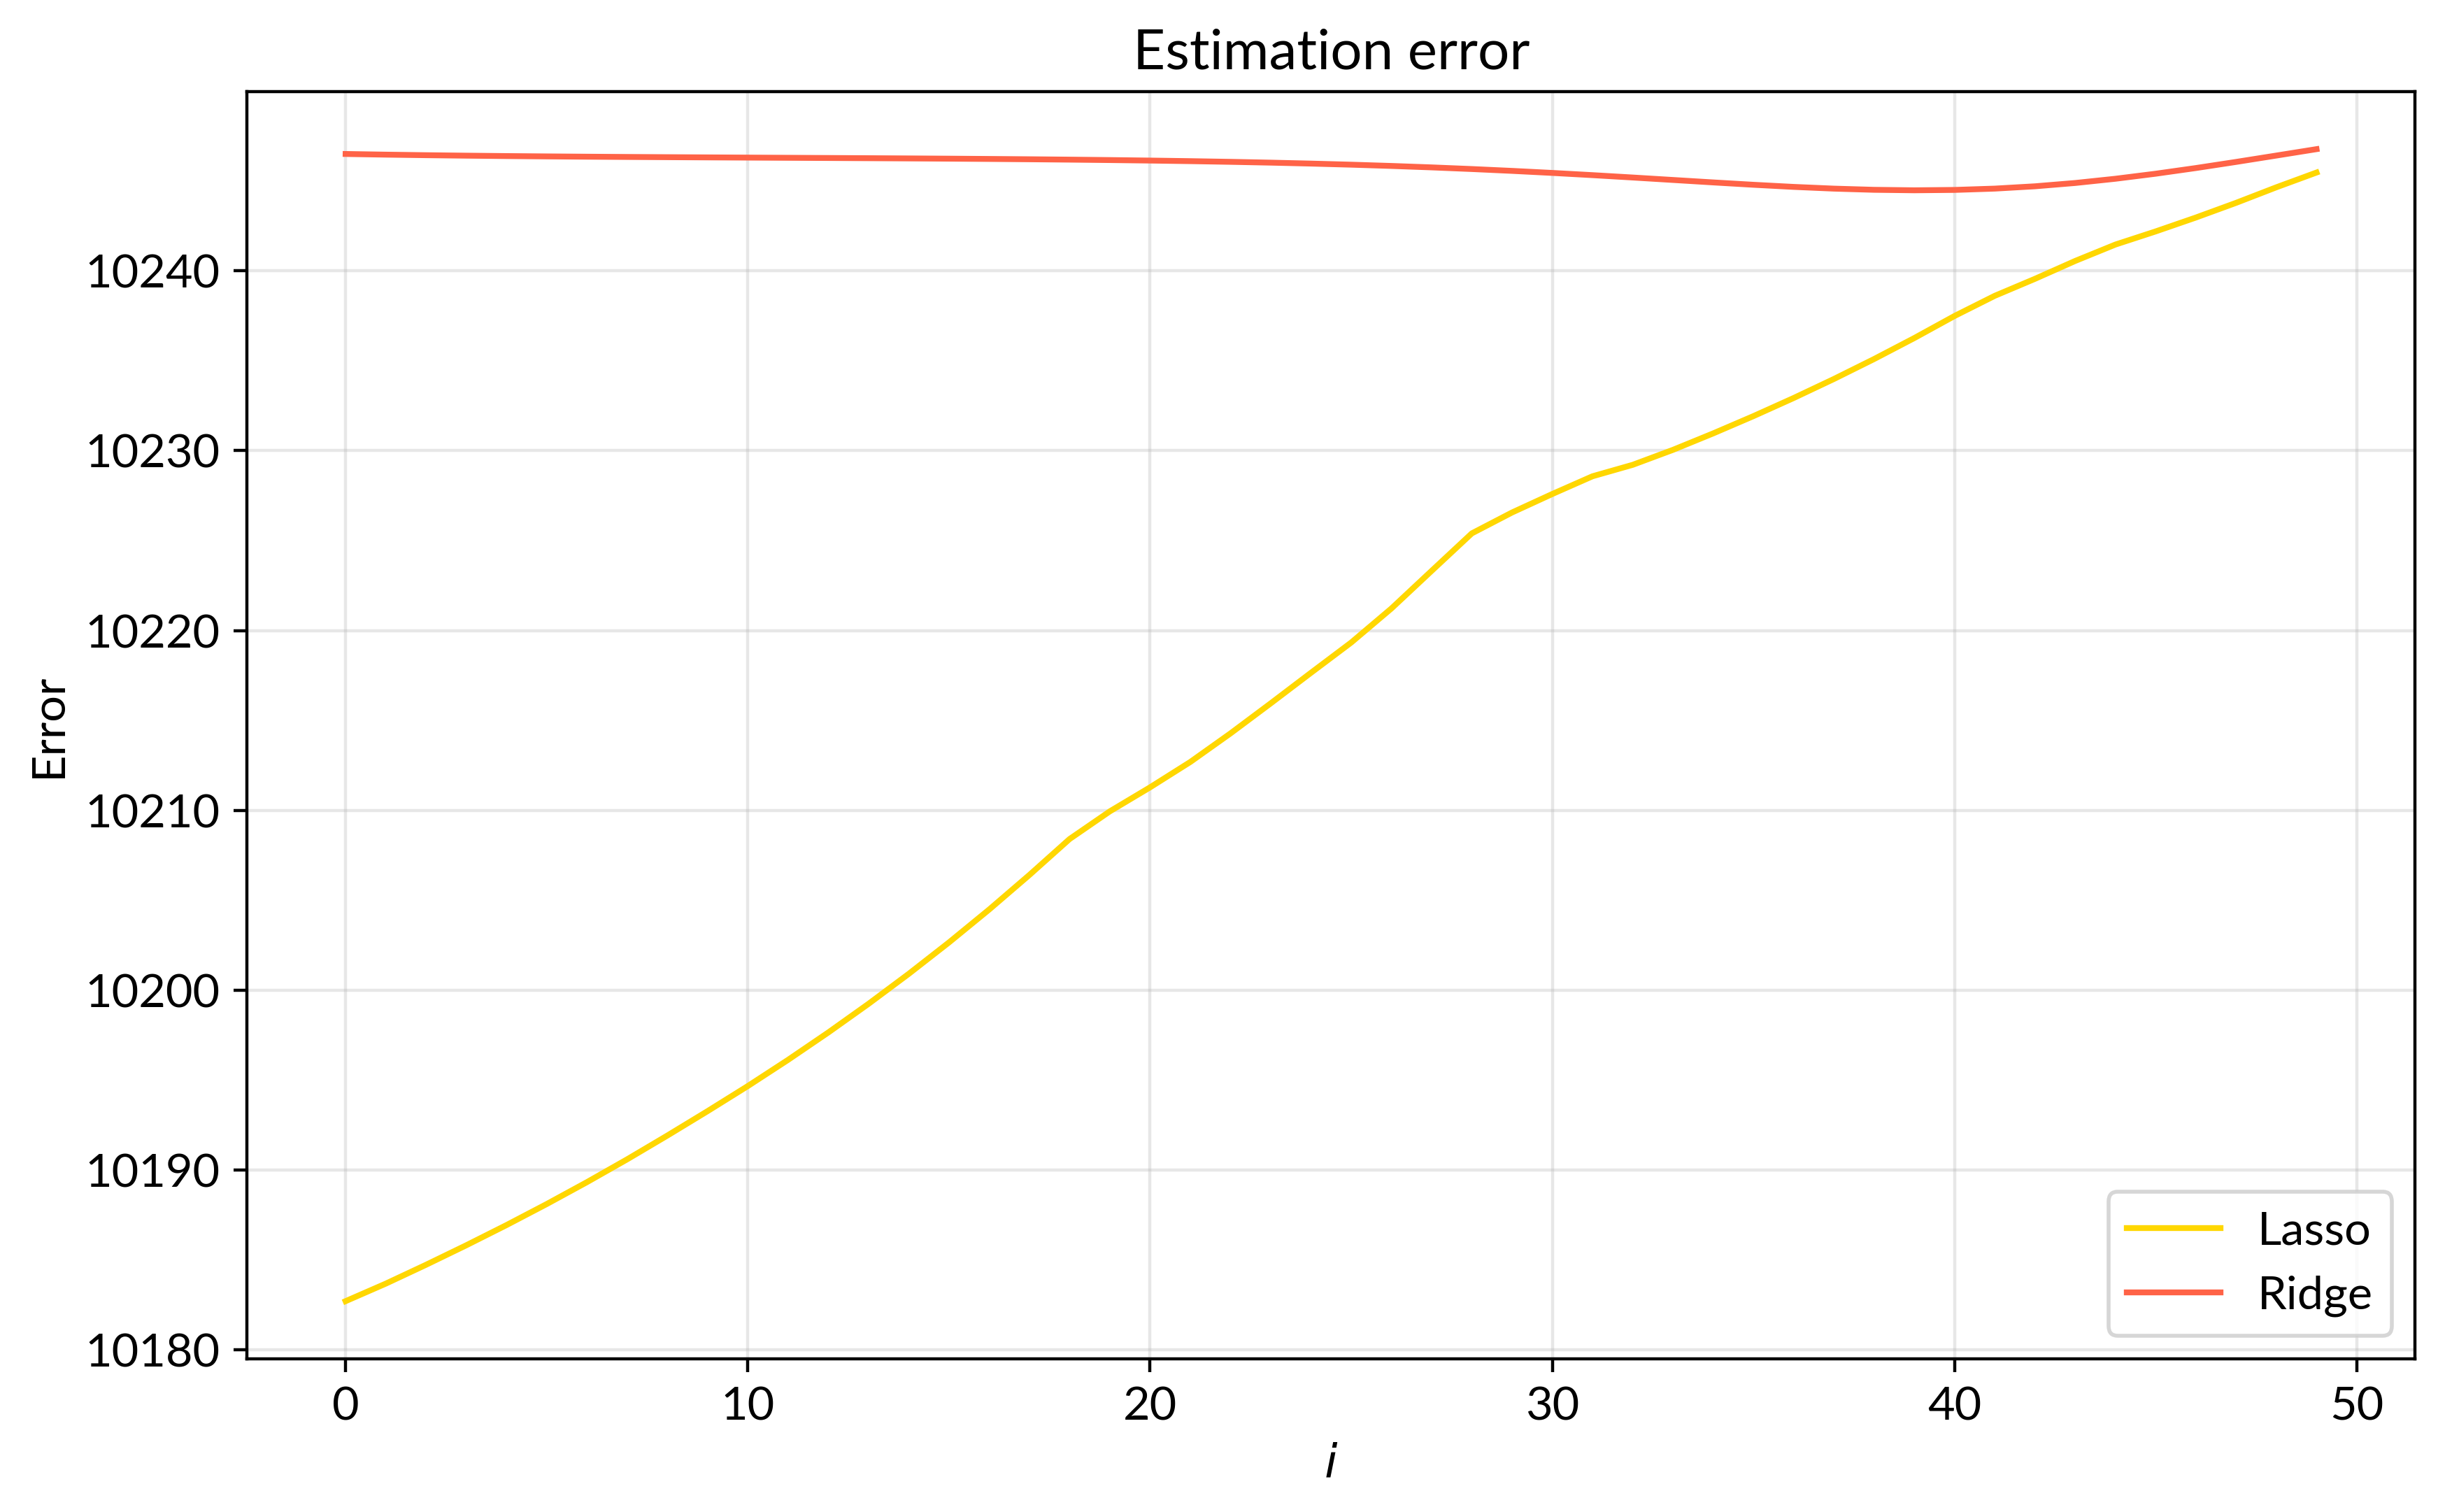

In [16]:
plt.plot(err_l, label='Lasso', color='gold')
plt.plot(err_r, label='Ridge', color='tomato')
plt.grid(alpha=0.3)
plt.xlabel('$i$')
plt.ylabel('Error')
plt.title('Estimation error')
plt.legend()
plt.show()

As we can see the ridge estimator has almost constant error, while the lasso performs better untill we don't crank up the coefficient too high.

We will repeat it for a random signal

In [17]:
beta_rnd = np.random.multivariate_normal(np.zeros(1000), np.identity(1000), 1).T
y_rnd = np.ones_like(eps) * beta_rnd[0] + X @ beta_rnd + eps
y_rnd.shape

N = len(eps)
beta_l_random = np.zeros((N, 1000))
beta_r_random = np.zeros((N, 1000))
for i, (lambda_l, lambda_r) in enumerate(zip(lambda_ls, lambda_rs)):
    beta_l_random[i, :] = lasso(X, y_rnd, lambda_l)
    beta_r_random[i, :] = ridge(X, y_rnd, lambda_r)

In [18]:
err_l_rnd = []
err_r_rnd = []
for i in range(len(lambda_ls)):
    err_l_rnd.append(np.linalg.norm(beta - beta_l_random[i, :], 2) ** 2)
    err_r_rnd.append(np.linalg.norm(beta - beta_r_random[i, :], 2) ** 2)

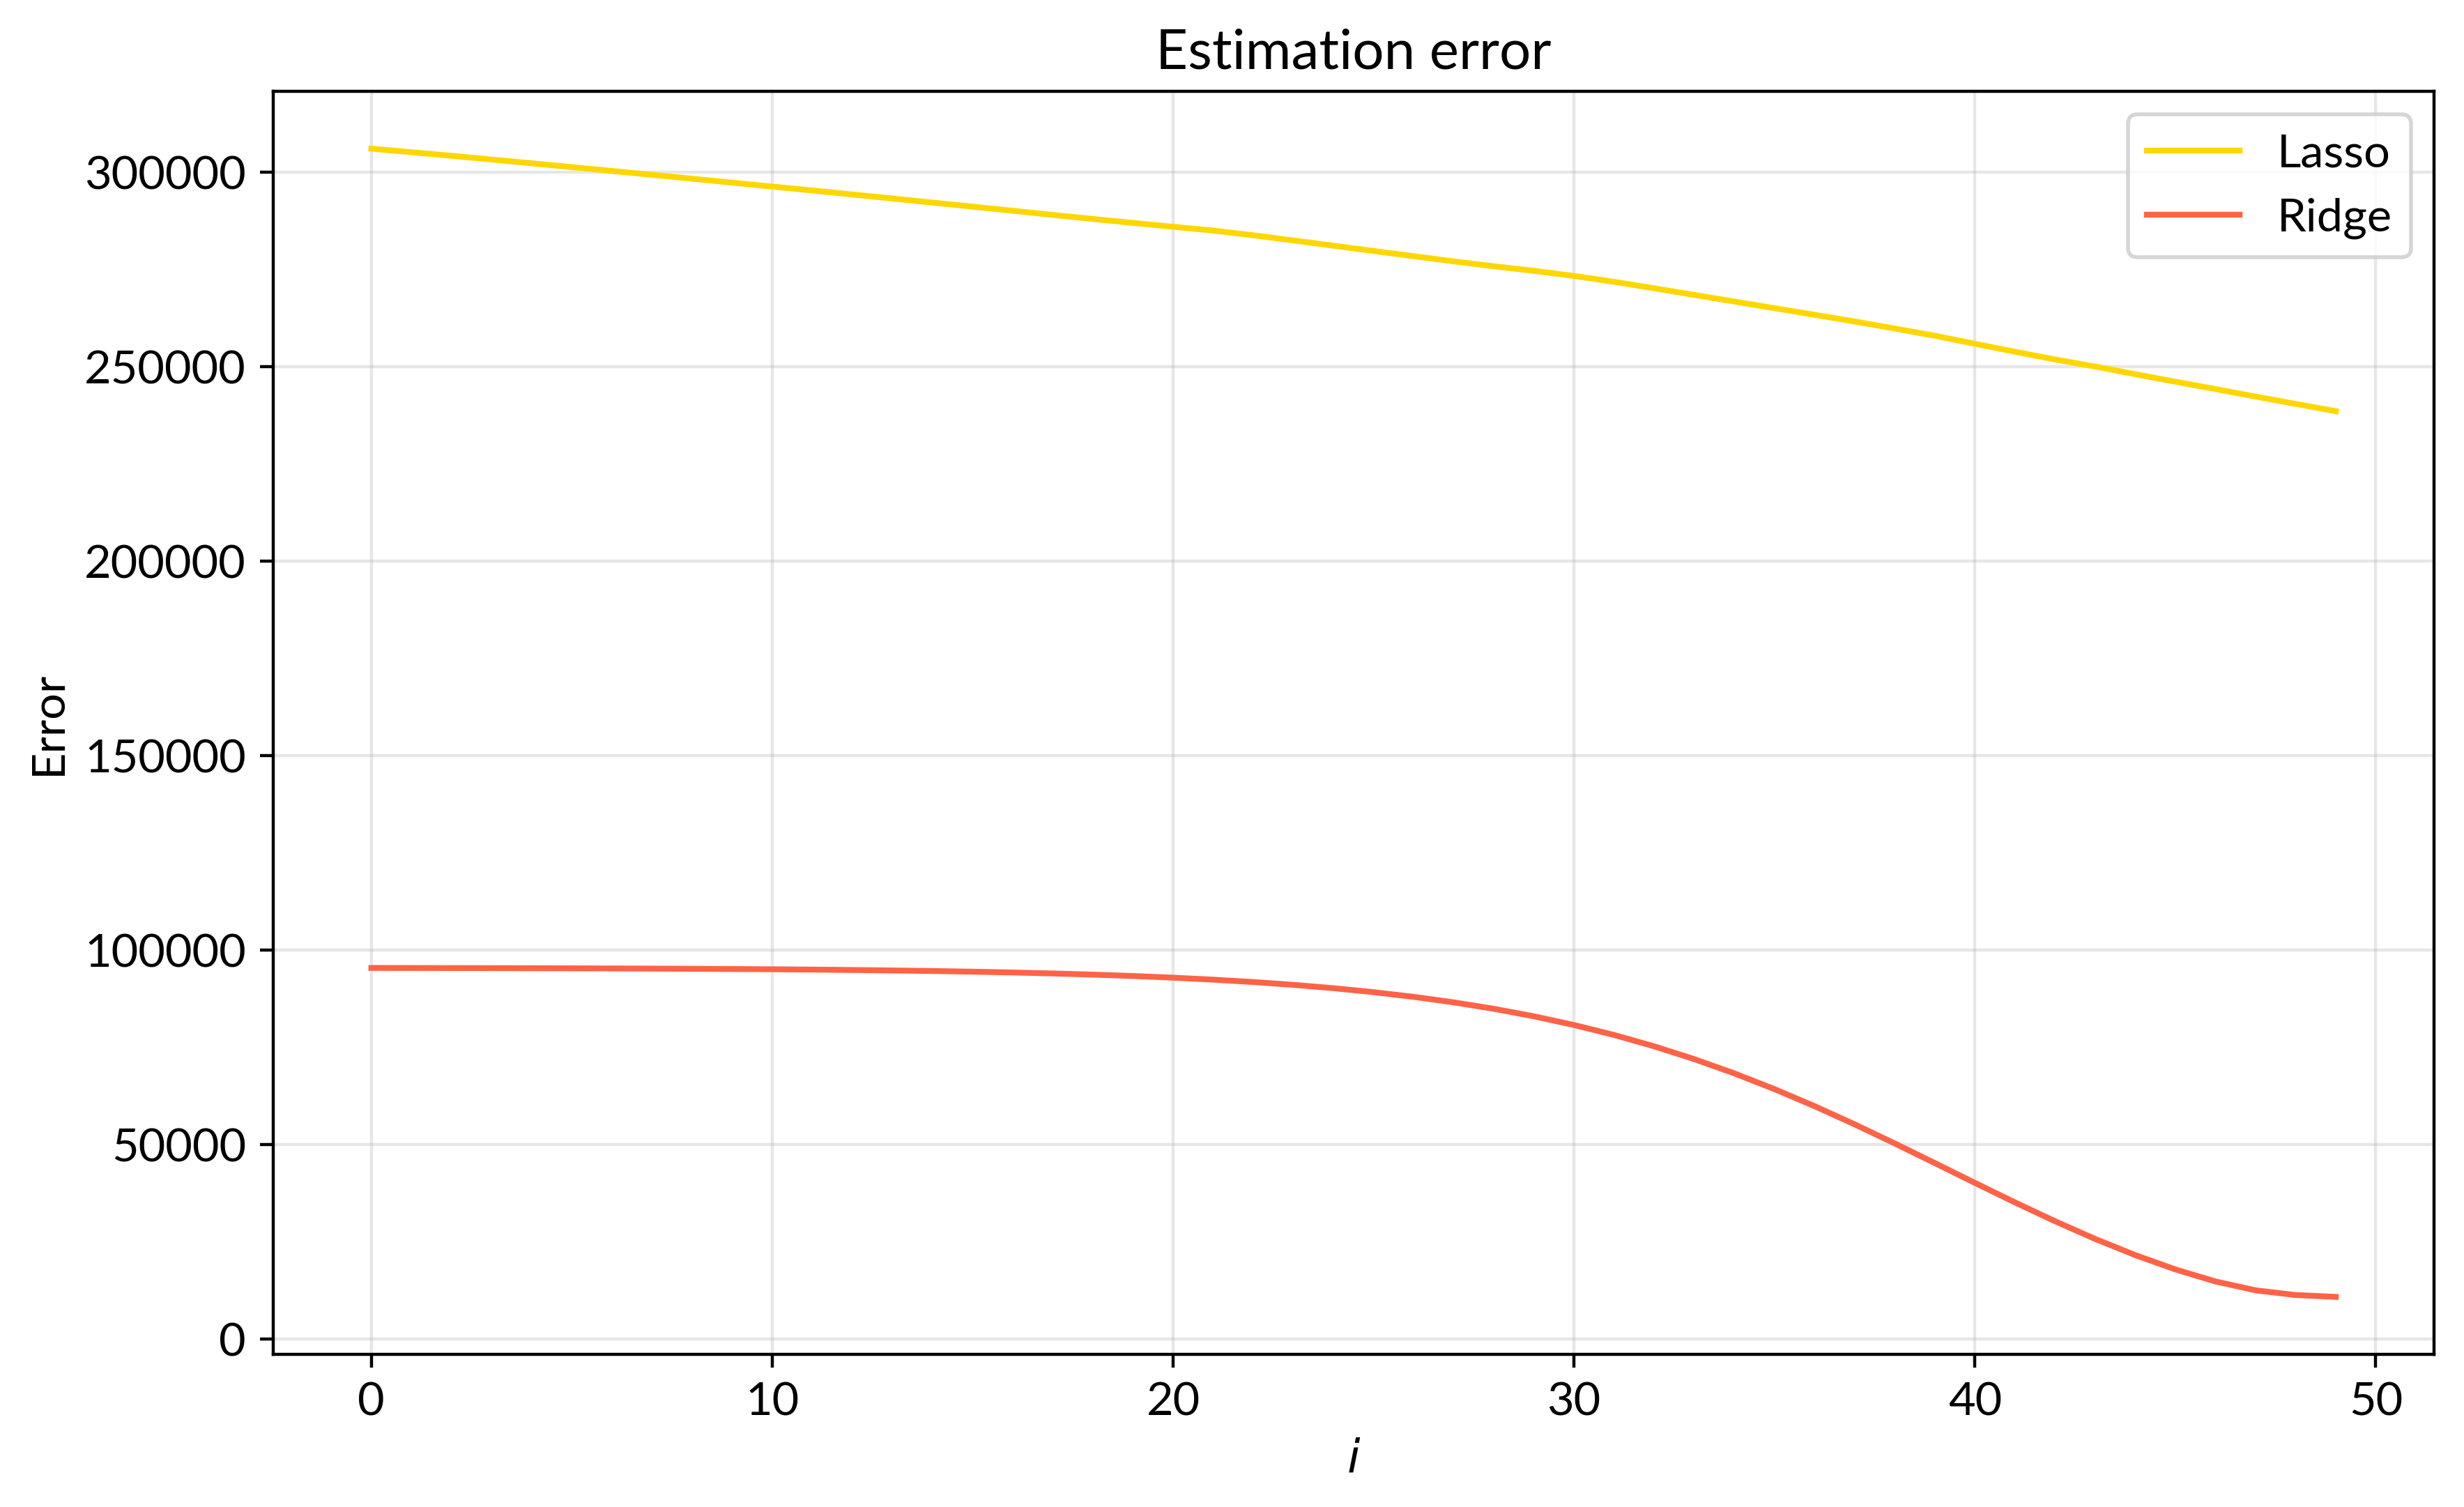

In [19]:
plt.plot(err_l_rnd, label='Lasso', color='gold')
plt.plot(err_r_rnd, label='Ridge', color='tomato')
plt.grid(alpha=0.3)
plt.xlabel('$i$')
plt.ylabel('Error')
plt.title('Estimation error')
plt.legend()
plt.show()

As we don't have a sparse signal, the lasso method performs constantly worse than ridge regression.

# Exercise 3
Use LASSO with $10$-fold cross-validation for $X$ and observations $y$ generated for the sparse vector $\beta$ from exercise 2 (i.e. $\beta$ with $10$ nonzero entries). Does CV recover all nonzero entries? Does it produce some false discoveries?

In [20]:
lasso_cv = sklearn.linear_model.LassoCV(cv=10, random_state=0).fit(X, y.flatten())

We will plot estimated and the true solution

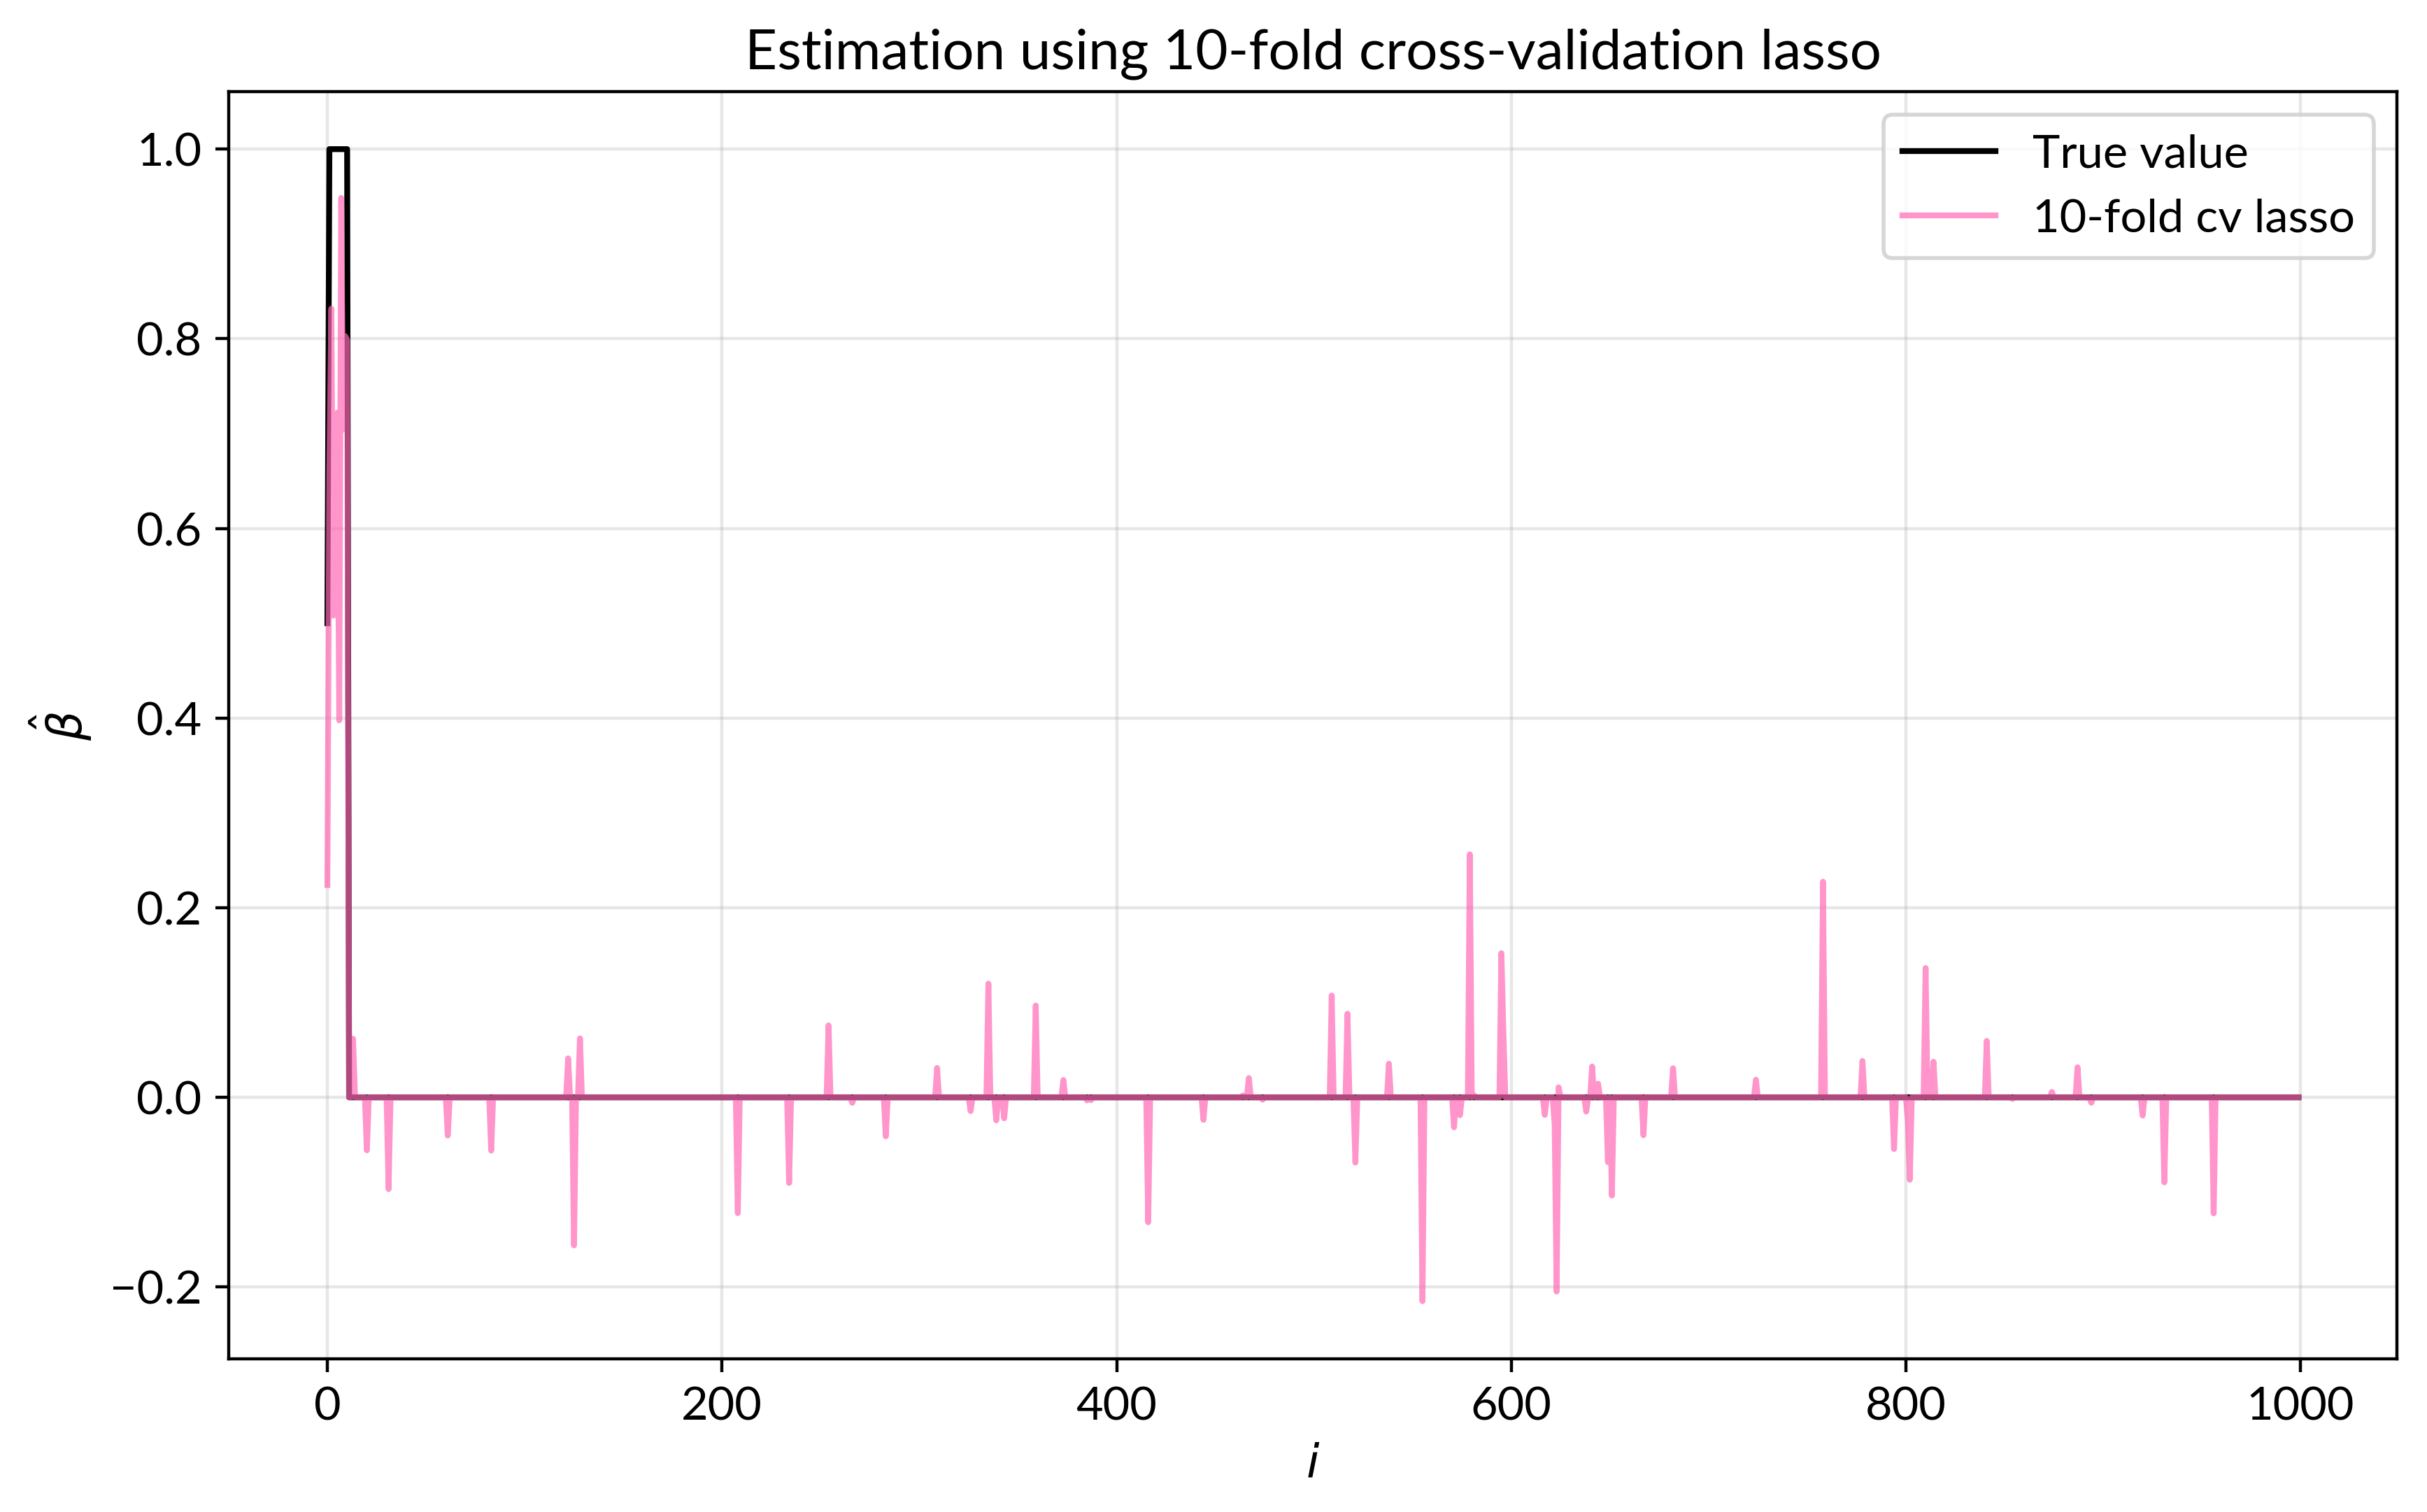

In [21]:
plt.plot(beta, label='True value', color='k')
plt.plot(lasso_cv.coef_, label='10-fold cv lasso', color='hotpink', alpha=0.7)
plt.grid(alpha=0.3)
plt.xlabel(r'$i$')
plt.ylabel(r'$\hat{\beta}$')
plt.title('Estimation using 10-fold cross-validation lasso')
plt.legend()
plt.show()

As we can see the 10-fold cross-validation lasso method found all nonzero entries of the $\beta$ vector, but it also produced a lot o false discoveries. But, as we can see, **they are visibly smaller in magnitude, so we could probably get rid of them using some threshold.**